In [1]:
# This code splits the given dataset to test-train files.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scienceplots
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import os

# Apply the default theme
#sns.set_theme()
#sns.set_style('white')
#sns.set_context("paper", font_scale = 2)
#plt.style.use(['science','no-latex'])
print('Pandas v', pd.__version__)

Pandas v 1.3.5


# Configurations

In [2]:
# Configurations 
#latex_dir = Path(r"C:\Users\3057550\OneDrive - Queen's University Belfast\ECIT\Research\AI_Cybersecurity\Teams Files\Papers\In preparation\NLP for SQLi detection\latex\hybrid_nlp_journal")
latex_dir = Path(r"C:\Users\kasim\OneDrive - Queen's University Belfast\ECIT\Research\AI_Cybersecurity\Teams Files\Papers\In preparation\NLP for SQLi detection\latex\hybrid_nlp_journal")
SAVE_OUTPUTS = True

In [3]:
# Notes about result files:
# 'results_230214_205321.pkl' # classical ML - Dataset: Train Kaggle, Test Kaggle
# 'results_230214_210527.pkl' # classical ML - Dataset: Train Harika, Test Harika
# 'results_230214_211201.pkl' # classical ML- Dataset: Train: Harika.train, Test: Kaggle.test

# 'results_230214_205100.pkl' # bert - Dataset: Train Kaggle, Test Kaggle
# '??.pkl' # bert- Dataset: Train Harika, Test Harika
# 'results_230214_193603.pkl' # bert- Dataset: Train: Harika.train, Test: Kaggle.test
main_folder = Path('../')


results_file = main_folder / 'results_230214_205321.pkl' # classical ML
results_file_bert = main_folder / 'results_230214_205100.pkl' # bert
print(results_file.is_file())
print(results_file_bert.is_file())

True
True


In [4]:
methods={}

methods['classic_ml'] = ['bow_nb', 'bow_xgboost', 'bow_svm', 'boc_nb', 'boc_xgboost', 'boc_svm',
       'tfidf_nb', 'tfidf_xgboost', 'tfidf_svm', 'tfidfng_nb',
       'tfidfng_xgboost', 'tfidfng_svm']
methods['hybrid'] = ['hybrid1_nb', 'hybrid1_xgboost',
       'hybrid1_svm', 'hybrid1_all_ml_averaged', 'hybrid2_boc',
       'hybrid2_tfidf', 'hybrid2_tfidf_ng', 'hybrid3', 'hybrid4_nb',
       'hybrid4_xgboost', 'hybrid4_svm']
methods['transformer'] = ['bert_en_uncased_L-12_H-768_A-12',
       'bert_en_cased_L-12_H-768_A-12',
       'small_bert/bert_en_uncased_L-2_H-128_A-2',
       'small_bert/bert_en_uncased_L-4_H-512_A-8',
       'small_bert/bert_en_uncased_L-8_H-128_A-2',
       'small_bert/bert_en_uncased_L-12_H-768_A-12',
       'bert_multi_cased_L-12_H-768_A-12', 'albert_en_base', 'electra_base',
       'electra_small']
method_categories = [method_cat for method_cat in methods]

# Load and Setup Data

In [5]:
# Rename Columns and Index properly (for latex tables and figures)
def rename_table_labels(df_bad_labeled):
    column_mapper = {
        "overall_accuracy": "Accuracy", 
        "precision": "Precision",
        "recall":"Recall",
        "f1":"F1",
        "tn":"TN",
        "tp":"TP",
        "fn":"FN",
        "fp":"FP",
        "train size":"Train Size",
        "test size":"Test Size",
        "train data":"Train Data",
        "test data":"Test Data",
        "training time":"Training Time (ms)",
        "testing time":"Inference Time (ms)",
        "log(f1/s)":"F1 Efficiency"
        }
    index_mapper = {
        "bow_nb": "BoW NB",
        "bow_xgboost": "BoW XGBoost", 
        'bow_svm':'BoW SVM',
        'boc_nb': 'BoC NB', 
        'boc_xgboost':'BoC XGBoost', 
        'boc_svm': 'BoC SVM',
        'tfidf_nb': 'TF-IDF NB', 
        'tfidf_xgboost': 'TF-IDF XGBoost', 
        'tfidf_svm': 'TF-IDF SVM', 
        'tfidfng_nb': 'TF-IDF ngram NB',
        'tfidfng_xgboost': 'TF-IDF ngram XGBoost', 
        'tfidfng_svm': 'TF-IDF ngram SVM', 
        'hybrid1_nb': 'Hybrid-1 NB', 
        'hybrid1_xgboost': 'Hybrid-1 XGBoost',
        'hybrid1_svm': 'Hybrid-1 SVM', 
        'hybrid1_all_ml_averaged': 'Hybrid-1 All', 
        'hybrid2_boc': 'Hybrid-2 BoC',
        'hybrid2_tfidf': 'Hybrid-2 TF-IDF', 
        'hybrid2_tfidf_ng': 'Hybrid-2 TF-IDF ngram', 
        'hybrid3': 'Hybrid-3', 
        'hybrid4_nb': 'Hybrid-4 NB',
        'hybrid4_xgboost': 'Hybrid-4 XGBoost', 
        'hybrid4_svm': 'Hybrid-4 SVM', 
        'bert_en_uncased_L-12_H-768_A-12' : 'BERT UL12H768A12',
        'bert_en_cased_L-12_H-768_A-12' : 'BERT CL12H768A12',
        'small_bert/bert_en_uncased_L-2_H-128_A-2' : 'BERT small UL2H128A2',
        'small_bert/bert_en_uncased_L-4_H-512_A-8' : 'BERT small UL4H512A8',
        'small_bert/bert_en_uncased_L-8_H-128_A-2' : 'BERT small UL8H128A2',
        'small_bert/bert_en_uncased_L-12_H-768_A-12' : 'BERT small UL12H768A12',
        'bert_multi_cased_L-12_H-768_A-12' : 'BERT MCL12H768A12', 
        'albert_en_base' : 'ALBERT', 
        'electra_base' : 'ELECTRA',
        'electra_small': 'ELECTRA small'
    }
    
    df_new_labeled = df_bad_labeled.rename(columns=column_mapper, index=index_mapper)
    df_new_labeled.index.rename("Method",inplace=True)
    return df_new_labeled

## Function definitions

In [6]:
#fig, ax = plt.subplots(figsize=(5, 5))
def my_plot_bar(df_small, ax, metric='f1', width=0.9, offset=0):
    
    
    col_names = df_small.columns
    row_names = df_small.index
    
    colors = df_small.loc[:,'color'].values
    colors = [list(colors[i][0]) for i in range(len(colors))]

    bar_vals = df_small.loc[:][metric].values.tolist()
    bar_tics = df_small.loc[:][metric].index.tolist()
    bar_width = width

    bar_container = ax.bar(x=np.arange(len(bar_tics))+offset, height=bar_vals, 
                           width=bar_width,color=colors, tick_label=bar_tics)
    ax.bar_label(bar_container, fmt='%0.4f', padding=0.8, rotation=90)
    
    #ax.tick_params(axis='x', rotation=70, ha="right")
    plt.setp(ax.get_xticklabels(), rotation=70, ha="right", rotation_mode="default")
    plt.setp(ax.get_xticklabels(),  va="center", rotation_mode="anchor")
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.tick_params(axis='y', which='both', right=False)
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    #ax.set(ylim=(0.8, 1))




In [7]:
#fig, ax = plt.subplots(figsize=(5, 5))
def my_plot_twin_bar(df_small, ax, metric=['F1','Inference Time (ms)']):
    width = 0.3
    offset = 0.3
    my_plot_bar(df_small, ax, metric[0],width=width,offset=0)

    ax2 = ax.twinx()
    ax2.tick_params(axis='x', which='both', bottom=False, top=False)
    ax2.spines.top.set_visible(False)
    # col_names = df_small.columns
    # row_names = df_small.index
    
    colors = df_small.loc[:,'color'].values
    colors = [list(colors[i][0]) for i in range(len(colors))]
    new_colors = np.asarray(colors)/[3.2, 3.2, 3.2, 1]
    new_colors = new_colors.sum(axis=1)-1
    new_colors = np.expand_dims(new_colors, axis=0)
    new_colors = np.tile(new_colors.transpose(),(1,4))
    new_colors[:,3] =1
    colors = new_colors.tolist()
    

    bar_vals = df_small.loc[:][metric[1]].values.tolist()
    bar_tics = df_small.loc[:][metric[1]].index.tolist()
    bar_width = width

    bar_container = ax2.bar(x=np.arange(len(bar_tics))+offset, height=bar_vals, 
                           width=bar_width,color=colors, tick_label=bar_tics)
    ax2.bar_label(bar_container, fmt='%0.4fms', padding=0.8, rotation=90)
    
    # #ax.tick_params(axis='x', rotation=70, ha="right")
    # plt.setp(ax.get_xticklabels(), rotation=70, ha="right", rotation_mode="default")
    # plt.setp(ax.get_xticklabels(),  va="center", rotation_mode="anchor")
    # ax.tick_params(axis='x', which='both', bottom=False, top=False)
    # ax.tick_params(axis='y', which='both', right=False)
    # # Hide the right and top spines
    # ax.spines.right.set_visible(False)
    # ax.spines.top.set_visible(False)

    return ax, ax2

    #ax.set(ylim=(0.8, 1))




## Read and preprocess dataset

In [8]:
#%%script echo skip
df = pd.read_pickle(results_file)
df2 = pd.read_pickle(results_file_bert)
df_all = pd.concat([df, df2])
#df_all
#df_all.loc["small_bert/bert_en_uncased_L-4_H-512_A-8":"electra_small","f1"]+1
#df_acc = (df_all.tn + df_all.tp).div(df_all.tn + df_all.tp + df_all.fn + df_all.fp)*100 #fill the missing accuracies that I forgot to record

#df_all.loc["small_bert/bert_en_uncased_L-4_H-512_A-8":"electra_small","overall_accuracy"] = df_acc.loc["small_bert/bert_en_uncased_L-4_H-512_A-8":"electra_small"]
#df_acc.loc["small_bert/bert_en_uncased_L-4_H-512_A-8":"electra_small"]

#df = df_all
#df

In [9]:
df = df_all.copy()

In [10]:
# Fix Nan value of hybrid1_all_ml_averaged

#df.loc["hybrid1_all_ml_averaged"]["training time"] = df.loc["hybrid1_nb":"hybrid1_svm"].sum()["training time"]
#df.loc["hybrid1_all_ml_averaged"]["testing time"] = df.loc["hybrid1_nb":"hybrid1_svm"].sum()["testing time"]
df.at["hybrid1_all_ml_averaged", "training time"] = df.loc["hybrid1_nb":"hybrid1_svm"].sum()["training time"]
df.at["hybrid1_all_ml_averaged", "testing time"] = df.loc["hybrid1_nb":"hybrid1_svm"].sum()["testing time"]
#df

In [11]:
# Normalize time (per sample/ms )
df.loc[:,"training time"] = df.loc[:,"training time"]*1000 / df.loc[:,"train size"]
df.loc[:,"testing time"] = df.loc[:,"testing time"]*1000 / df.loc[:,"test size"]

In [12]:
for method in methods:
    df.loc[methods[method], 'category'] = method

In [18]:
# set the colormap for each category (classical ml, hybrid, transformer)
metric='f1'
method_categories = [i for i in methods.keys()]
method_cat_cm_func = [plt.cm.BuPu, plt.cm.YlGn, plt.cm.OrRd]
df.loc[:, 'color'] = -1.0
for k, cat in enumerate(method_categories):
    cat_cm_func = method_cat_cm_func[k]
    df_small = df[df['category']==cat] # OR df.loc[methods[cat]]
    
    df_small = df_small.sort_values(metric,ascending=False)
    col_names = df_small.columns
    row_names = df_small.index

    colors = cat_cm_func(np.linspace(0.1, 0.6, len(row_names)))
    colors = colors[::-1]
    df_small.loc[:, 'color'] = [ 0 for i in range(len(row_names))]
    for i, row_name in enumerate(row_names):
        df_small.loc[row_name,'color'] = [[np.asarray(colors[i],dtype=float)]]
        #print(row_name, df_small.loc[row_name,'color'])
    df.update(df_small)

In [19]:
df

,overall_accuracy,precision,recall,f1,tn,fp,fn,tp,train size,test size,train data,test data,training time,testing time,category,color
bow_nb,98.513558,0.978317,0.982151,0.980230,3775.0,50.0,41.0,2256.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.000774,0.000326,classic_ml,"[[0.7155247981545559, 0.8041061130334486, 0.88..."
bow_xgboost,98.448220,0.996841,0.961689,0.978950,3818.0,7.0,88.0,2209.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.144264,0.004694,classic_ml,"[[0.764244521337947, 0.8389850057670126, 0.908..."
bow_svm,98.546227,0.995067,0.966043,0.980340,3814.0,11.0,78.0,2219.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,2.012650,0.297275,classic_ml,"[[0.6708650519031142, 0.7729796232218378, 0.87..."
boc_nb,92.045083,0.834442,0.983021,0.902658,3377.0,448.0,39.0,2258.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.000815,0.000815,classic_ml,"[[0.8978854286812764, 0.9390234525182622, 0.96..."
boc_xgboost,99.673309,0.999123,0.992164,0.995631,3823.0,2.0,18.0,2279.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.360882,0.005050,classic_ml,"[[0.5490196078431373, 0.5750096116878124, 0.77..."
boc_svm,99.640640,0.997376,0.993034,0.995201,3819.0,6.0,16.0,2281.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.421575,0.276956,classic_ml,"[[0.5700576701268744, 0.6326489811610919, 0.79..."
tfidf_nb,97.141457,0.969469,0.953853,0.961598,3756.0,69.0,106.0,2191.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.000285,0.000163,classic_ml,"[[0.812964244521338, 0.8758938869665513, 0.929..."
tfidf_xgboost,99.232277,0.999113,0.980409,0.989673,3823.0,2.0,45.0,2252.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.130031,0.002792,classic_ml,"[[0.5944175317185698, 0.6840753556324491, 0.82..."
tfidf_svm,98.546227,0.988928,0.972138,0.980461,3800.0,25.0,64.0,2233.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,1.403676,0.252273,classic_ml,"[[0.6221453287197232, 0.7390234525182623, 0.85..."
tfidfng_nb,92.273767,0.837029,0.986069,0.905457,3384.0,441.0,32.0,2265.0,24487.0,6122.0,SQLiV3_train.tsv,SQLiV3_test.tsv,0.000774,0.000494,classic_ml,"[[0.8576239907727797, 0.9097270280661285, 0.94..."


# Latex

## Latex Figures and Tables

In [20]:
# Figure configs
plt.rcParams.update({'figure.dpi': '300'})
plt.rcParams['font.family'] = "Times New Roman"

### All Sorted (F1 and inference time)

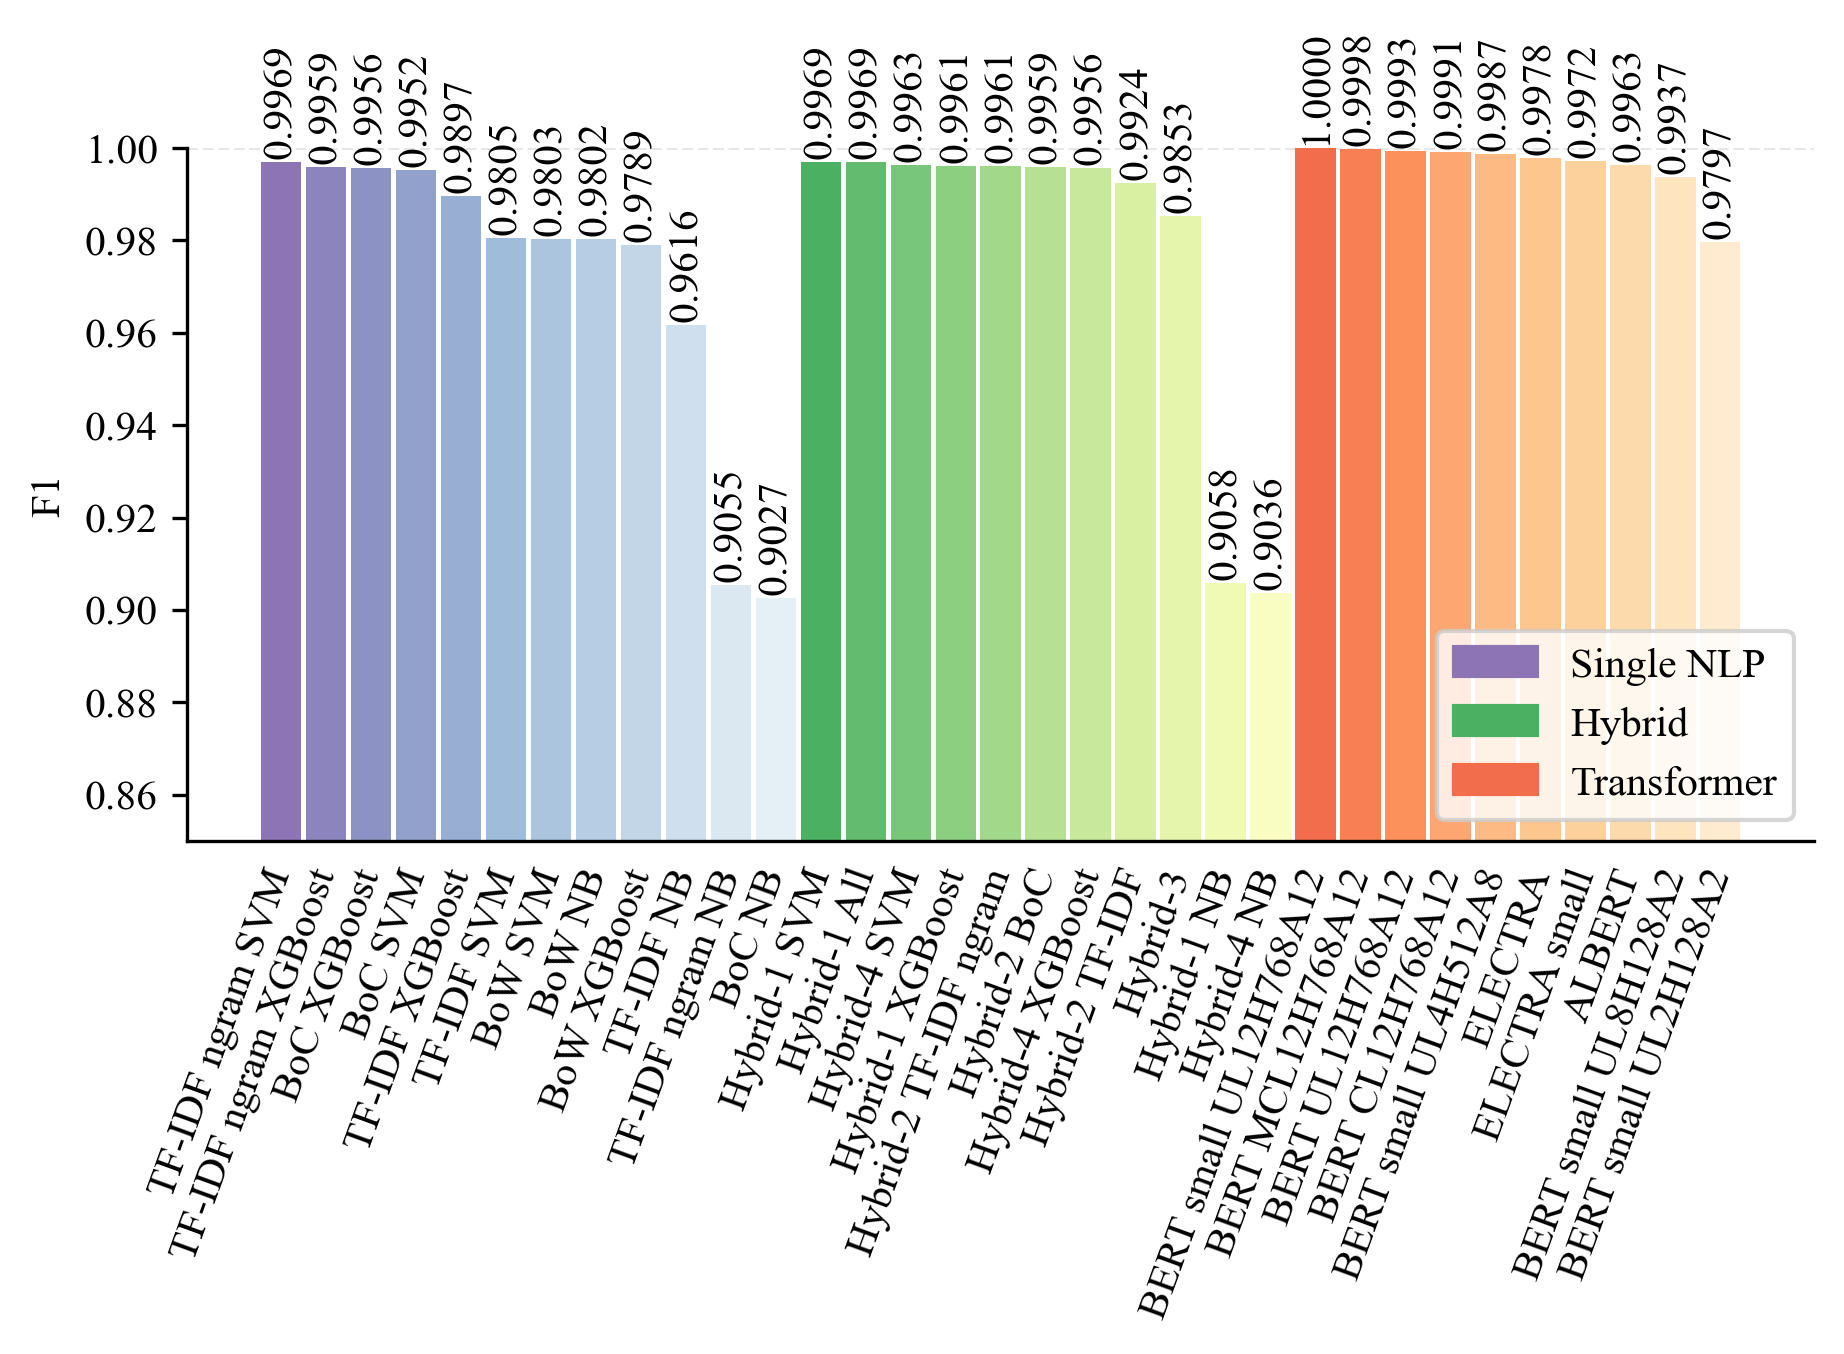

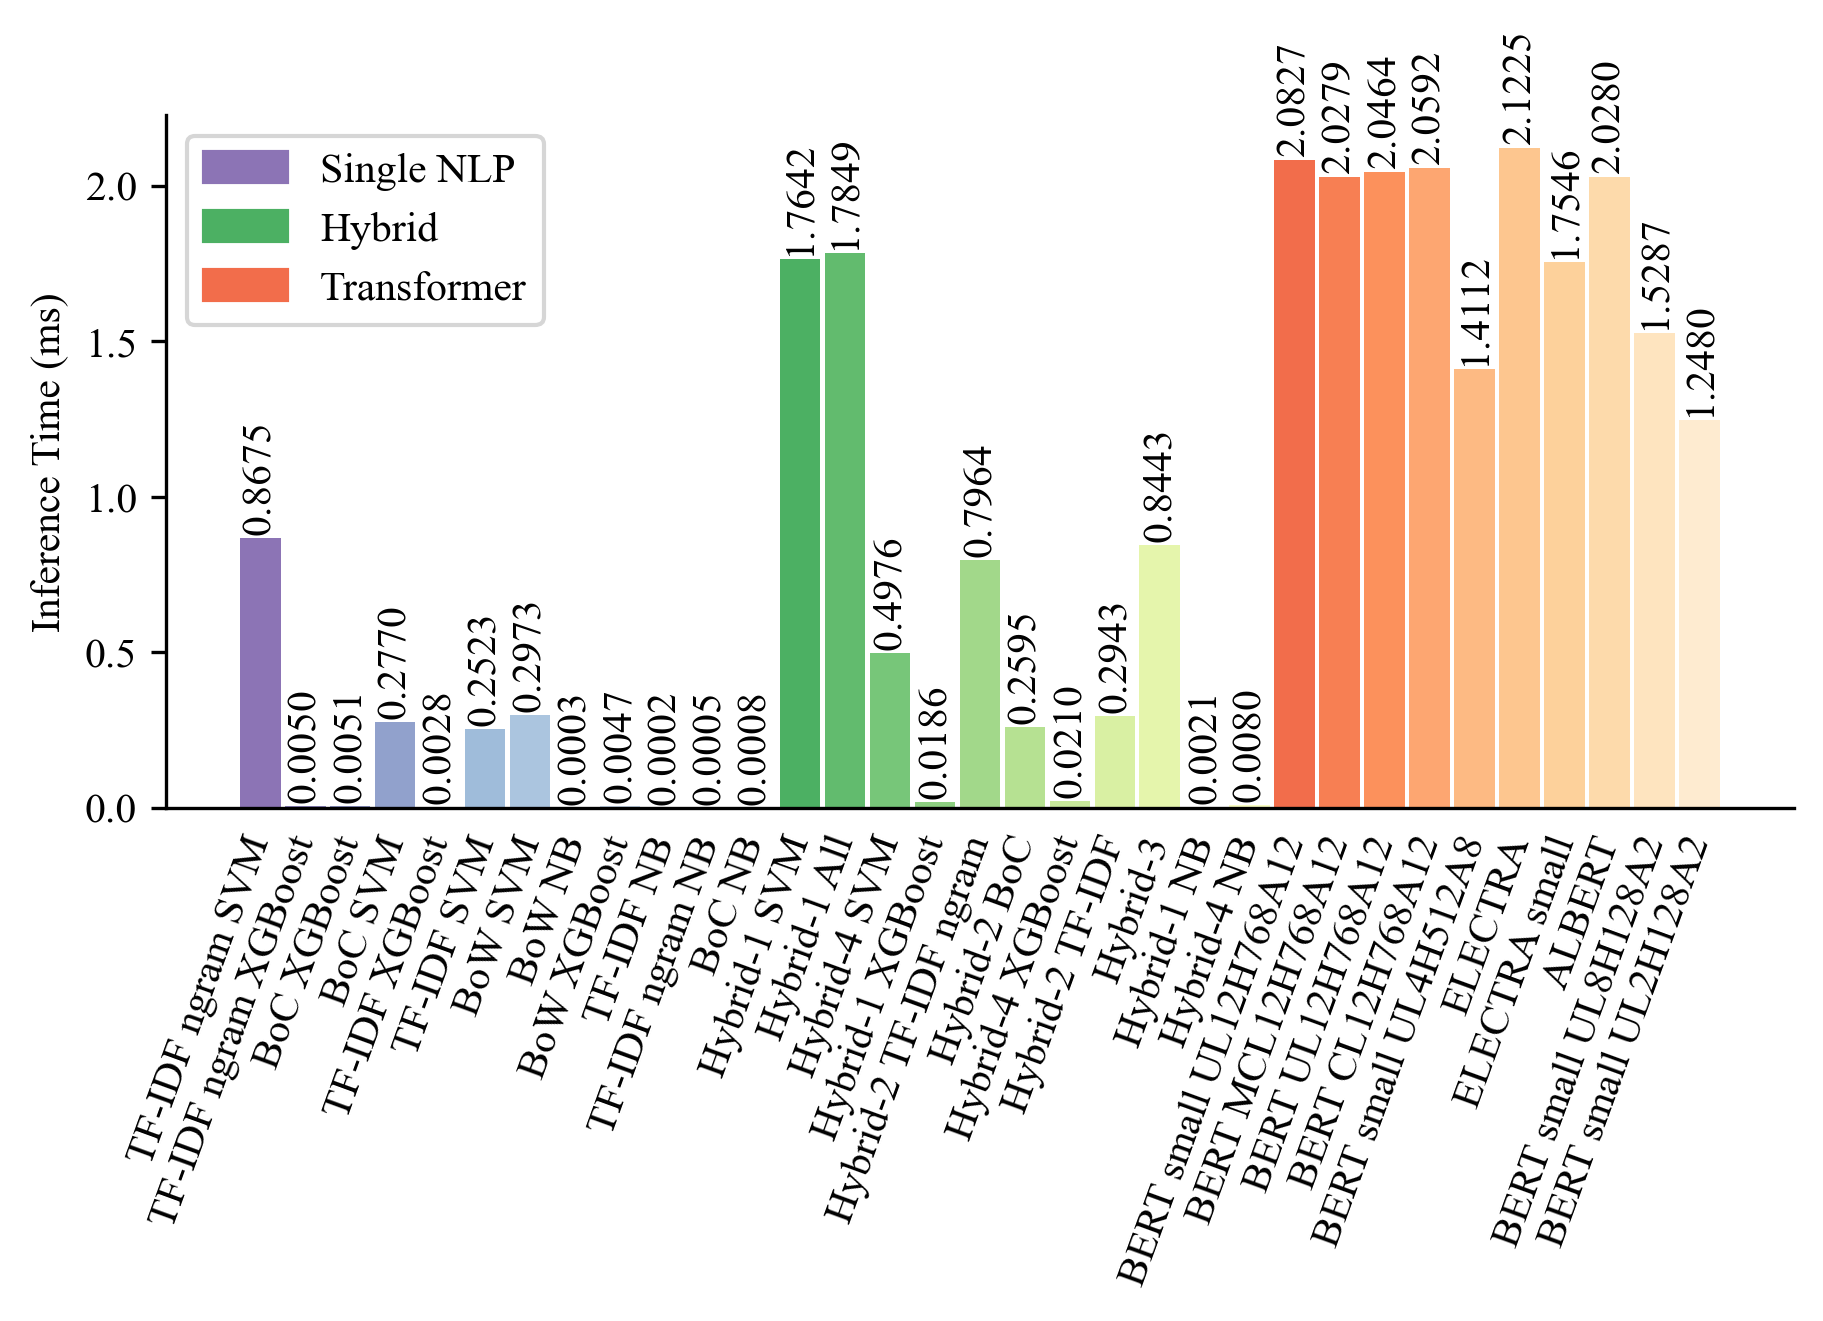

In [21]:
# method_category = 'transformer'
# metrics = ['overall_accuracy', 'precision', 'recall', 'f1', 'training time',
#        'testing time', 'color']
import matplotlib.patches as mpatches
df_small = df.sort_values(['category','f1'],ascending=[True, False])
df_small = rename_table_labels(df_small)
#df_small = df.loc[methods[method_category], metrics]
#df_small = df_small.sort_values(['category','f1'],ascending=[True, False])

# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='classic_ml'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
color_cat_2 = np.asarray(df_small[df_small['category']=='hybrid'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
color_cat_3 = np.asarray(df_small[df_small['category']=='transformer'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
legend_cat_1 = mpatches.Patch(color=color_cat_1, label='Single NLP')
legend_cat_2 = mpatches.Patch(color=color_cat_2, label='Hybrid')
legend_cat_3 = mpatches.Patch(color=color_cat_3, label='Transformer')

# Figure
fig, ax = plt.subplots(figsize=(7, 3))
my_plot_bar(df_small,ax,'F1')
plt.axhline(1, linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set(ylim=(0.85, 1))
ax.set_ylabel('F1')
ax.legend(handles=[legend_cat_1, legend_cat_2, legend_cat_3],  loc='lower right')

fig, ax = plt.subplots(figsize=(7, 3))
my_plot_bar(df_small,ax,'Inference Time (ms)')
ax.set_ylabel('Inference Time (ms)')
ax.legend(handles=[legend_cat_1, legend_cat_2, legend_cat_3],  loc='upper left')

In [22]:
import pathlib
table_folder= latex_dir / "Tables"
figure_folder= latex_dir / "Figures"
assert (table_folder.is_dir()), "No such folder"
assert (figure_folder.is_dir()), "No such folder"



In [23]:
def process_style_to_my_latex_format(df_latex):
    # returns style object
    s = df_latex.reset_index().style.hide_index()
    s = s.format(precision=4, escape="latex")
    return s

### Single NLP (F1 vs Inference)

In [37]:
# Table: Single NLP
table_name = "single"
caption="Accuracy and inference speed of single NLP methods."
out_file_name = (table_folder / table_name).with_suffix('.tex') 
method_cat = 'classic_ml'
metrics = ['overall_accuracy', 'precision', 'recall', 'f1', 'training time',
       'testing time', 'color', 'category']

df_small = df.loc[df['category']==method_cat,metrics]

df_small = rename_table_labels(df_small)
#print(df_small)

s = process_style_to_my_latex_format(df_small.drop(['color', 'category'], axis=1 ))

s = s.highlight_max(props='textbf:--rwrap;', subset=s.columns[1:-2])
s = s.highlight_min(props='textbf:--rwrap;', subset=s.columns[-2:])

if SAVE_OUTPUTS:
    s.to_latex(buf=out_file_name,
       column_format="lrrrrrr", position="htbp", position_float="centering",
       hrules=True, label=f"tab:{table_name}", caption=caption)

print(s.to_latex(
    column_format="lrrrrrr", position="ht", position_float="centering",
    hrules=True, label=f"table:{table_name}", caption=caption)
)
#df.loc[:,"training time"] / df.loc[:,"train size"]
#(df.loc[:,["training time", "testing time"]]*1000).div(df.loc[:,["train size", "test size"]])

\begin{table}[ht]
\centering
\caption{Accuracy and inference speed of single NLP methods.}
\label{table:single}
\begin{tabular}{lrrrrrr}
\toprule
{Method} & {Accuracy} & {Precision} & {Recall} & {F1} & {Training Time (ms)} & {Inference Time (ms)} \\
\midrule
BoW NB & 98.5136 & 0.9783 & 0.9822 & 0.9802 & 0.0008 & 0.0003 \\
BoW XGBoost & 98.4482 & 0.9968 & 0.9617 & 0.9789 & 0.1443 & 0.0047 \\
BoW SVM & 98.5462 & 0.9951 & 0.9660 & 0.9803 & 2.0127 & 0.2973 \\
BoC NB & 92.0451 & 0.8344 & 0.9830 & 0.9027 & 0.0008 & 0.0008 \\
BoC XGBoost & 99.6733 & 0.9991 & 0.9922 & 0.9956 & 0.3609 & 0.0051 \\
BoC SVM & 99.6406 & 0.9974 & 0.9930 & 0.9952 & 0.4216 & 0.2770 \\
TF-IDF NB & 97.1415 & 0.9695 & 0.9539 & 0.9616 & \textbf{0.0003} & \textbf{0.0002} \\
TF-IDF XGBoost & 99.2323 & 0.9991 & 0.9804 & 0.9897 & 0.1300 & 0.0028 \\
TF-IDF SVM & 98.5462 & 0.9889 & 0.9721 & 0.9805 & 1.4037 & 0.2523 \\
TF-IDF ngram NB & 92.2738 & 0.8370 & 0.9861 & 0.9055 & 0.0008 & 0.0005 \\
TF-IDF ngram XGBoost & 99.6896 & 0.99

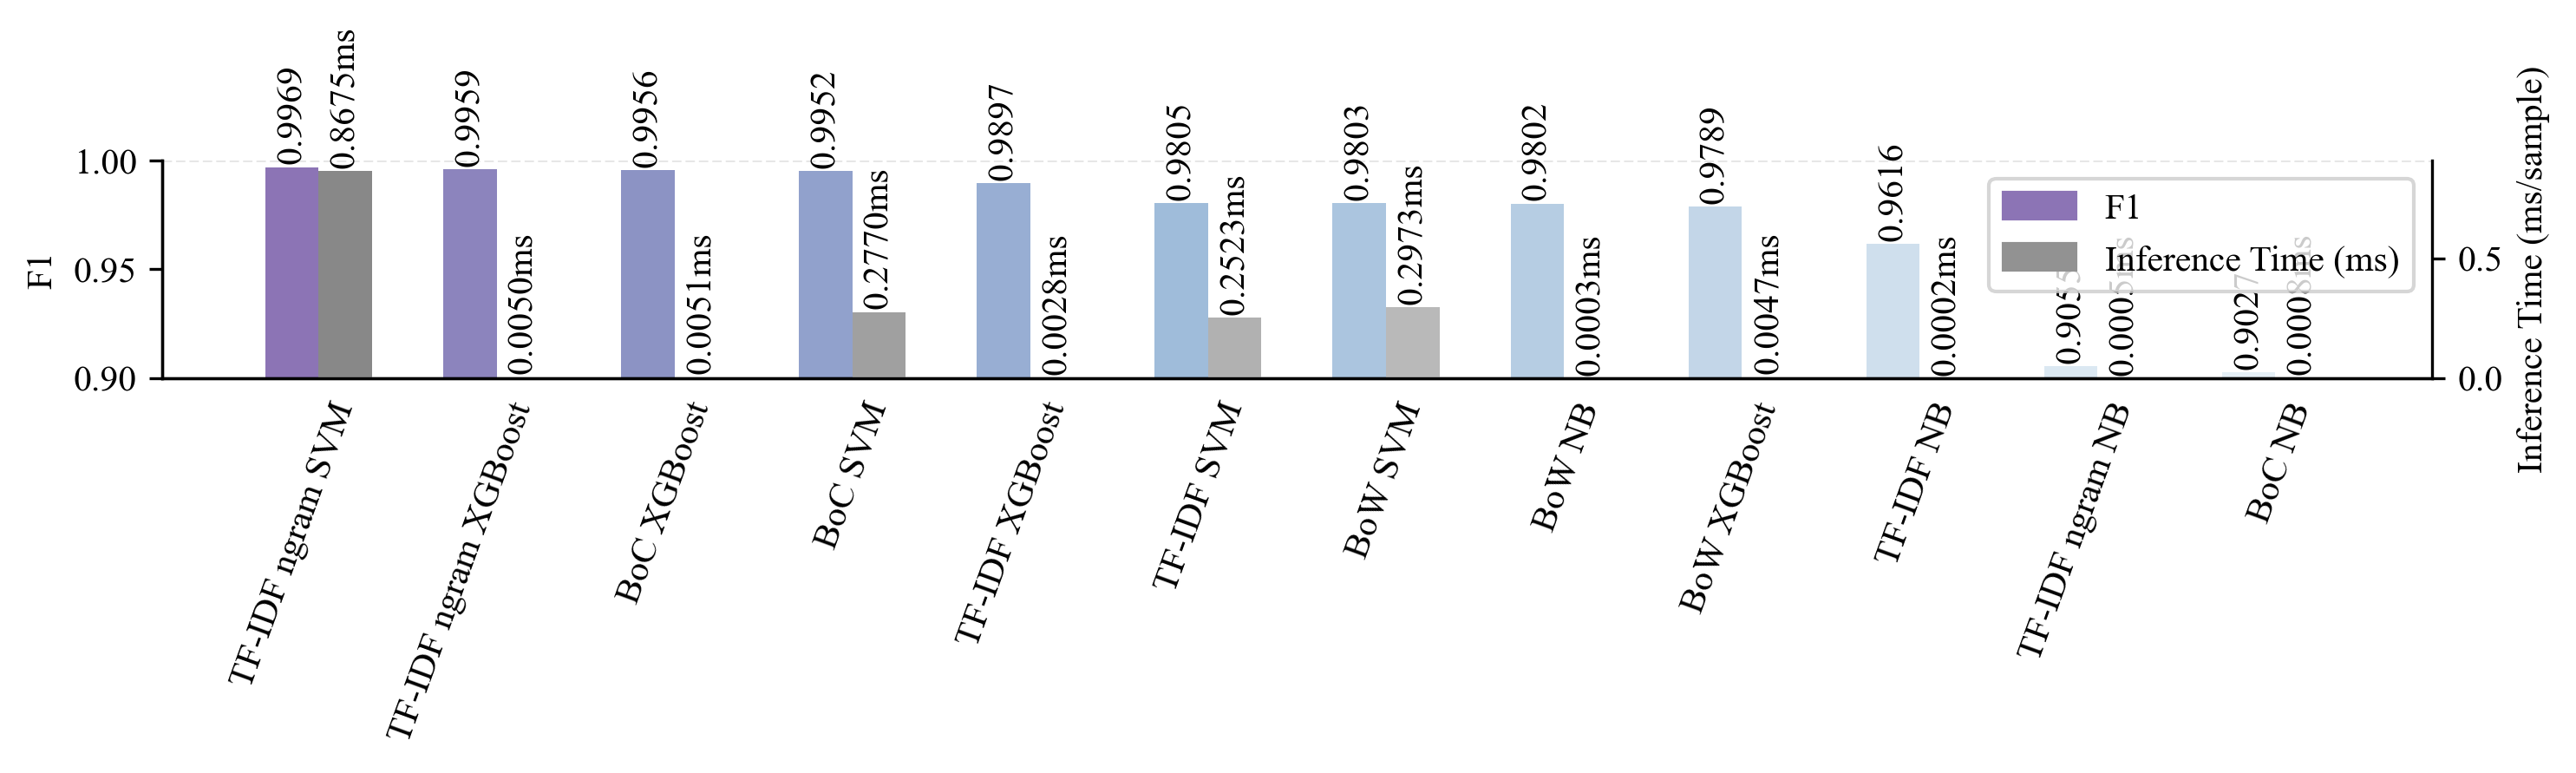

In [38]:
# Figure of Table Single NLP
current_figure_name = 'single_nlp_f1_vs_time.png'
fig, ax = plt.subplots( figsize=(10,3))

metric = ['F1', 'Inference Time (ms)']
df_small = df_small.sort_values(metric,ascending=False)

# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='classic_ml'] 
                         .head(1)['color'].values[0][0], dtype=np.float32)
color_cat_1G = color_cat_1.copy()
color_cat_1G[0:3] = color_cat_1G[0:3].mean()

legend_cat_1 = mpatches.Patch(color=color_cat_1, label=metric[0])
legend_cat_1G = mpatches.Patch(color=color_cat_1G, label=metric[1])



_, ax2 = my_plot_twin_bar(df_small,ax,metric)
ax.axhline(1,  linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set(ylim=(0.90, 1))
ax.set_ylabel('F1')

if SAVE_OUTPUTS:
    ax.get_figure().savefig(figure_folder / current_figure_name)


ax2.set_ylabel('Inference Time (ms/sample)')
# #ax.set(ylim=(0.95, 1))
ax2.legend(handles=[legend_cat_1, legend_cat_1G],  loc='upper right')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax2.get_figure().savefig(figure_folder / current_figure_name)


### Table Hybrid NLP

In [39]:
# Table: Hybrid NLP
table_name = "hybrid"
caption="Accuracy and inference speed of hybrid NLP methods."
out_file_name = (table_folder / table_name).with_suffix('.tex') 
method_cat = 'hybrid'
metrics = ['overall_accuracy', 'precision', 'recall', 'f1', 'training time',
       'testing time', 'color', 'category']

df_small = df.loc[df['category']==method_cat,metrics]

df_small = rename_table_labels(df_small)
#print(df_small)

s = process_style_to_my_latex_format(df_small.drop(['color', 'category'], axis=1 ))


s = s.highlight_max(props='textbf:--rwrap;', subset=s.columns[1:-2])
s = s.highlight_min(props='textbf:--rwrap;', subset=s.columns[-2:])

if SAVE_OUTPUTS:
       s.to_latex(buf=out_file_name,
              column_format="lrrrrrr", position="htbp", position_float="centering",
              hrules=True, label=f"tab:{table_name}", caption=caption)

print(s.to_latex(
    column_format="lrrrrrr", position="ht", position_float="centering",
    hrules=True, label=f"table:{table_name}", caption=caption)
)

\begin{table}[ht]
\centering
\caption{Accuracy and inference speed of hybrid NLP methods.}
\label{table:hybrid}
\begin{tabular}{lrrrrrr}
\toprule
{Method} & {Accuracy} & {Precision} & {Recall} & {F1} & {Training Time (ms)} & {Inference Time (ms)} \\
\midrule
Hybrid-1 NB & 92.3064 & 0.8376 & 0.9861 & 0.9058 & \textbf{0.0019} & \textbf{0.0021} \\
Hybrid-1 XGBoost & 99.7060 & 0.9991 & 0.9930 & 0.9961 & 1.5898 & 0.0186 \\
Hybrid-1 SVM & \textbf{99.7713} & \textbf{1.0000} & 0.9939 & \textbf{0.9969} & 2.8310 & 1.7642 \\
Hybrid-1 All & \textbf{99.7713} & \textbf{1.0000} & 0.9939 & \textbf{0.9969} & 4.4226 & 1.7849 \\
Hybrid-2 BoC & 99.6896 & 0.9991 & 0.9926 & 0.9959 & 0.7442 & 0.2595 \\
Hybrid-2 TF-IDF & 99.4283 & 0.9961 & 0.9887 & 0.9924 & 1.2487 & 0.2943 \\
Hybrid-2 TF-IDF ngram & 99.7060 & 0.9996 & 0.9926 & 0.9961 & 2.0160 & 0.7964 \\
Hybrid-3 & 98.8893 & 0.9785 & 0.9922 & 0.9853 & 1.0477 & 0.8443 \\
Hybrid-4 NB & 92.1268 & 0.8360 & 0.9830 & 0.9036 & 0.0124 & 0.0080 \\
Hybrid-4 XGBoost & 9

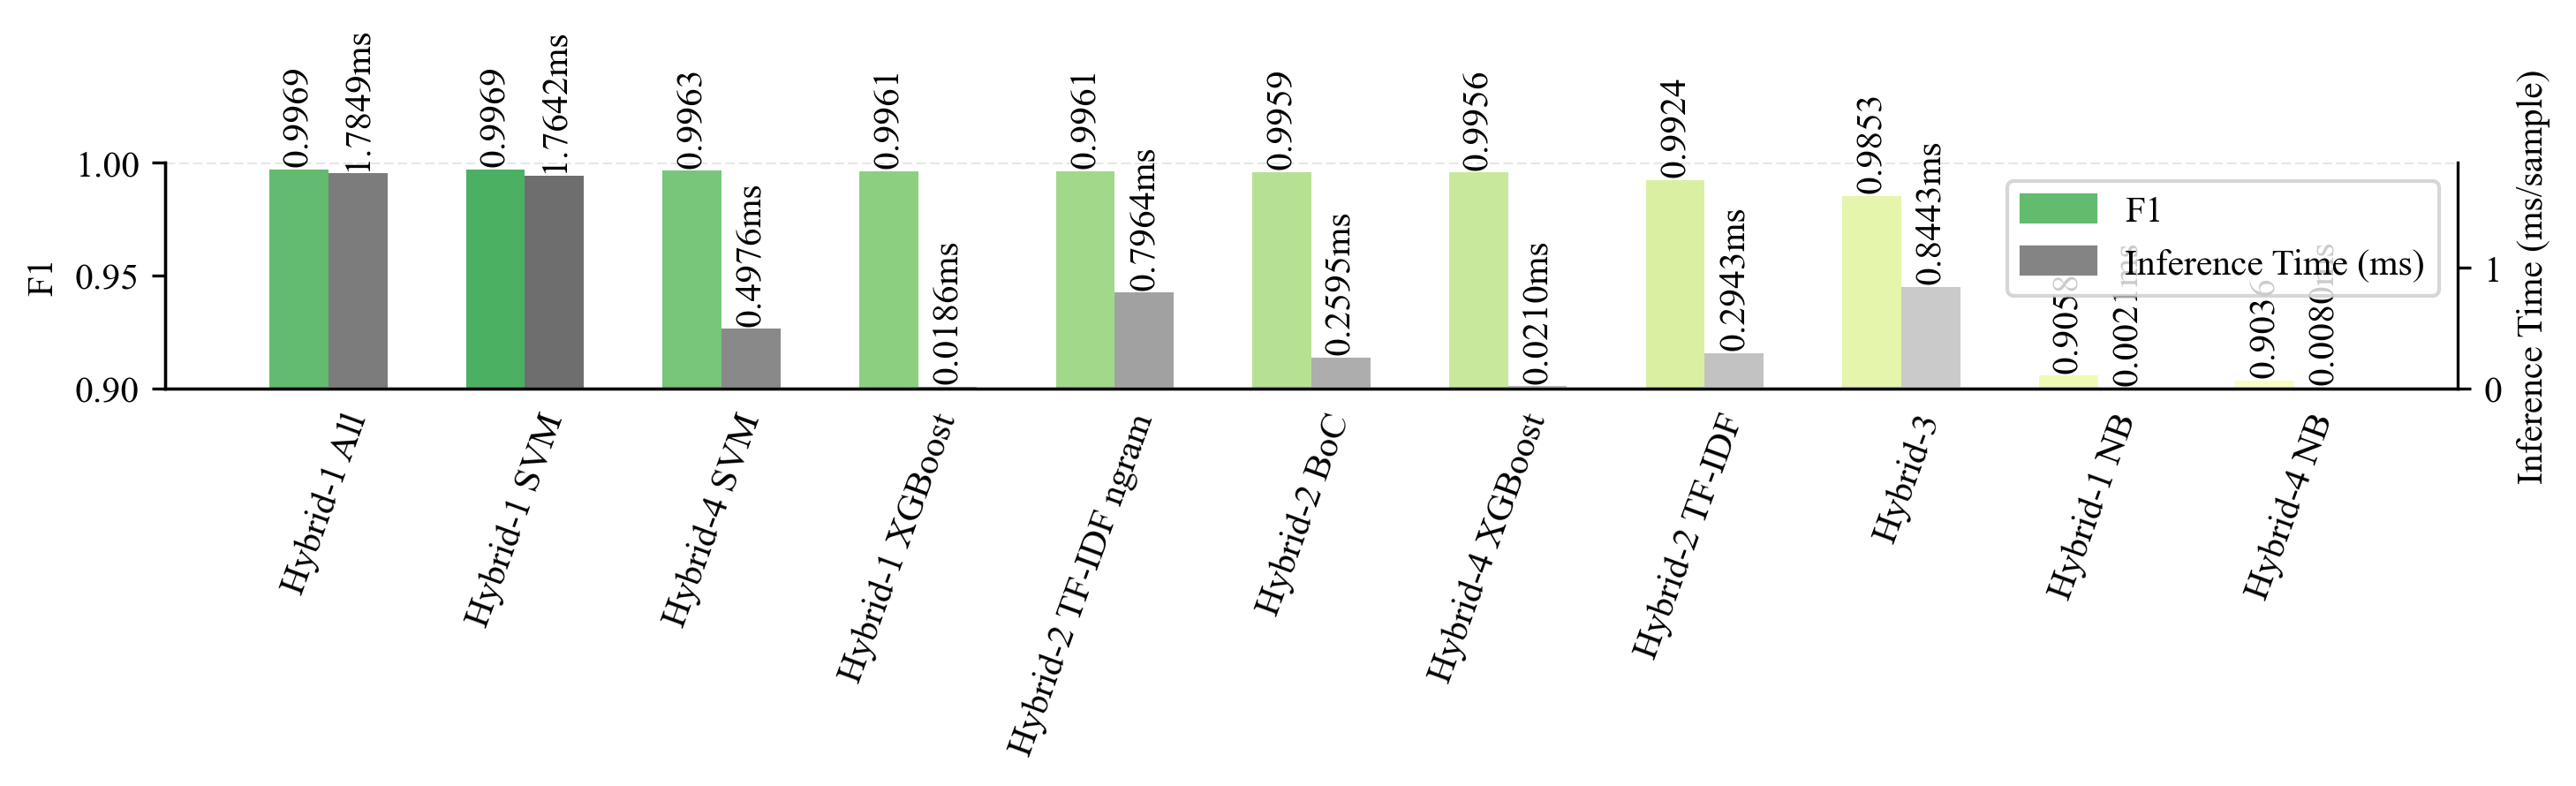

In [40]:
# Figure of Table Hybrid NLP
current_figure_name = 'hybrid_nlp_f1_vs_time.png'
fig, ax = plt.subplots( figsize=(10,3))

metric = ['F1', 'Inference Time (ms)']
df_small = df_small.sort_values(metric,ascending=False)

# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='hybrid'] 
                         .head(1)['color'].values[0][0], dtype=np.float32)
color_cat_1G = color_cat_1.copy()
color_cat_1G[0:3] = color_cat_1G[0:3].mean()

legend_cat_1 = mpatches.Patch(color=color_cat_1, label=metric[0])
legend_cat_1G = mpatches.Patch(color=color_cat_1G, label=metric[1])



_, ax2 = my_plot_twin_bar(df_small,ax,metric)
ax.axhline(1,  linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set(ylim=(0.90, 1))
ax.set_ylabel('F1')

if SAVE_OUTPUTS:
    ax.get_figure().savefig(figure_folder / current_figure_name)


ax2.set_ylabel('Inference Time (ms/sample)')
# #ax.set(ylim=(0.95, 1))
ax2.legend(handles=[legend_cat_1, legend_cat_1G],  loc='upper right')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax2.get_figure().savefig(figure_folder / current_figure_name)


### Transformers

In [41]:
# Table: Transformer NLP
table_name = "transformer"
caption="Accuracy and inference speed of trasnformer NLP methods."
out_file_name = (table_folder / table_name).with_suffix('.tex') 
method_cat = 'transformer'
metrics = ['overall_accuracy', 'precision', 'recall', 'f1', 'training time',
       'testing time', 'color', 'category']

df_small = df.loc[df['category']==method_cat,metrics]

df_small = rename_table_labels(df_small)
#print(df_small)

s = process_style_to_my_latex_format(df_small.drop(['color', 'category'], axis=1 ))


s = s.highlight_max(props='textbf:--rwrap;', subset=s.columns[1:-2])
s = s.highlight_min(props='textbf:--rwrap;', subset=s.columns[-2:])

if SAVE_OUTPUTS:
       s.to_latex(buf=out_file_name,
              column_format="lrrrrrr", position="htbp", position_float="centering",
              hrules=True, label=f"tab:{table_name}", caption=caption)

print(s.to_latex(
    column_format="lrrrrrr", position="ht", position_float="centering",
    hrules=True, label=f"table:{table_name}", caption=caption)
)

\begin{table}[ht]
\centering
\caption{Accuracy and inference speed of trasnformer NLP methods.}
\label{table:transformer}
\begin{tabular}{lrrrrrr}
\toprule
{Method} & {Accuracy} & {Precision} & {Recall} & {F1} & {Training Time (ms)} & {Inference Time (ms)} \\
\midrule
BERT UL12H768A12 & 0.9995 & \textbf{1.0000} & 0.9987 & 0.9993 & 18.2015 & 2.0464 \\
BERT CL12H768A12 & 0.9993 & 0.9996 & 0.9987 & 0.9991 & 18.2034 & 2.0592 \\
BERT small UL2H128A2 & 0.9848 & 0.9829 & 0.9765 & 0.9797 & \textbf{7.7301} & \textbf{1.2480} \\
BERT small UL4H512A8 & 0.9990 & \textbf{1.0000} & 0.9974 & 0.9987 & 9.5320 & 1.4112 \\
BERT small UL8H128A2 & 0.9953 & 0.9978 & 0.9896 & 0.9937 & 12.2345 & 1.5287 \\
BERT small UL12H768A12 & \textbf{1.0000} & \textbf{1.0000} & \textbf{1.0000} & \textbf{1.0000} & 18.2179 & 2.0827 \\
BERT MCL12H768A12 & 0.9998 & 0.9996 & \textbf{1.0000} & 0.9998 & 19.6089 & 2.0279 \\
ALBERT & 0.9972 & \textbf{1.0000} & 0.9926 & 0.9963 & 19.1457 & 2.0280 \\
ELECTRA & 0.9984 & 0.9978 & 0.9978

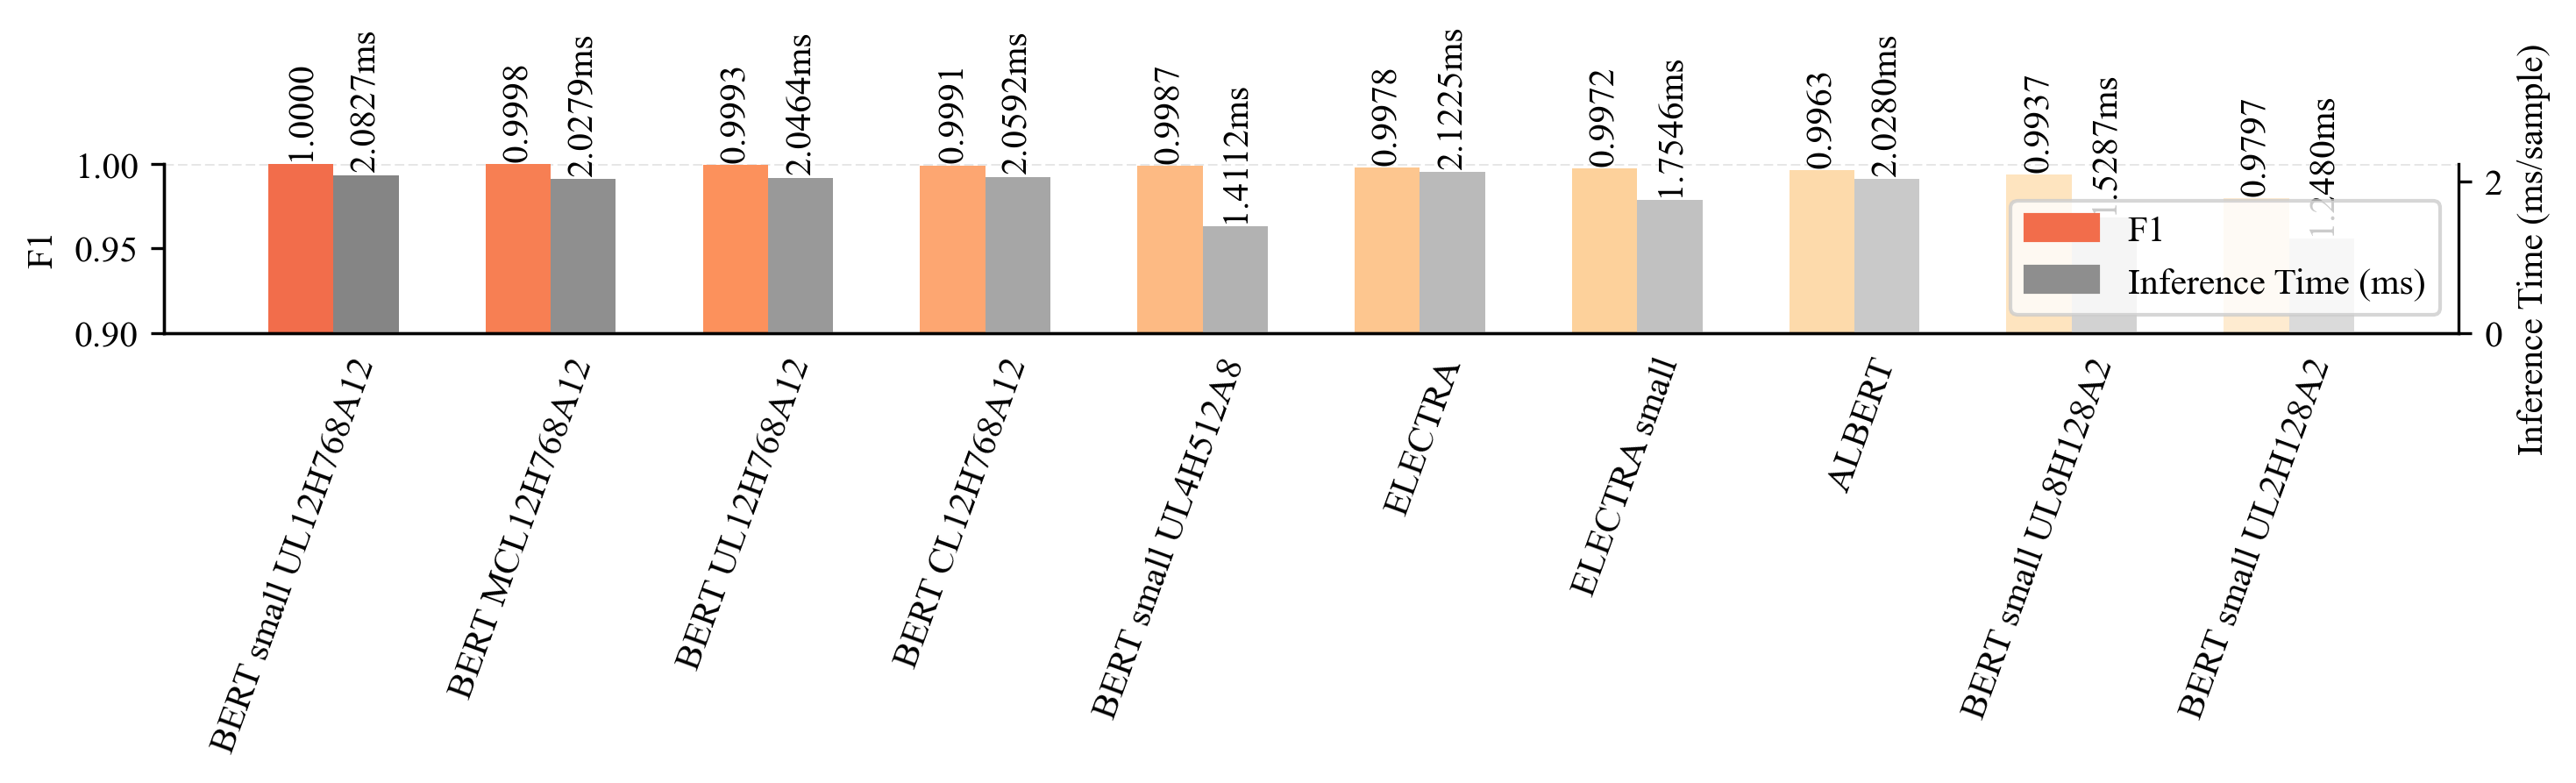

In [42]:
# Figure of Table Transformer NLP
current_figure_name = 'transformer_nlp_f1_vs_time.png'
fig, ax = plt.subplots( figsize=(10,3))

metric = ['F1', 'Inference Time (ms)']
df_small = df_small.sort_values(metric,ascending=False)

# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='transformer'] 
                         .head(1)['color'].values[0][0], dtype=np.float32)
color_cat_1G = color_cat_1.copy()
color_cat_1G[0:3] = color_cat_1G[0:3].mean()

legend_cat_1 = mpatches.Patch(color=color_cat_1, label=metric[0])
legend_cat_1G = mpatches.Patch(color=color_cat_1G, label=metric[1])



_, ax2 = my_plot_twin_bar(df_small,ax,metric)
ax.axhline(1,  linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set(ylim=(0.90, 1))
ax.set_ylabel('F1')

if SAVE_OUTPUTS:
    ax.get_figure().savefig(figure_folder / current_figure_name)


ax2.set_ylabel('Inference Time (ms/sample)')
# #ax.set(ylim=(0.95, 1))
ax2.legend(handles=[legend_cat_1, legend_cat_1G],  loc='lower right')
fig.tight_layout()
if SAVE_OUTPUTS:
    ax2.get_figure().savefig(figure_folder / current_figure_name)


### All methods FE score vs alpha

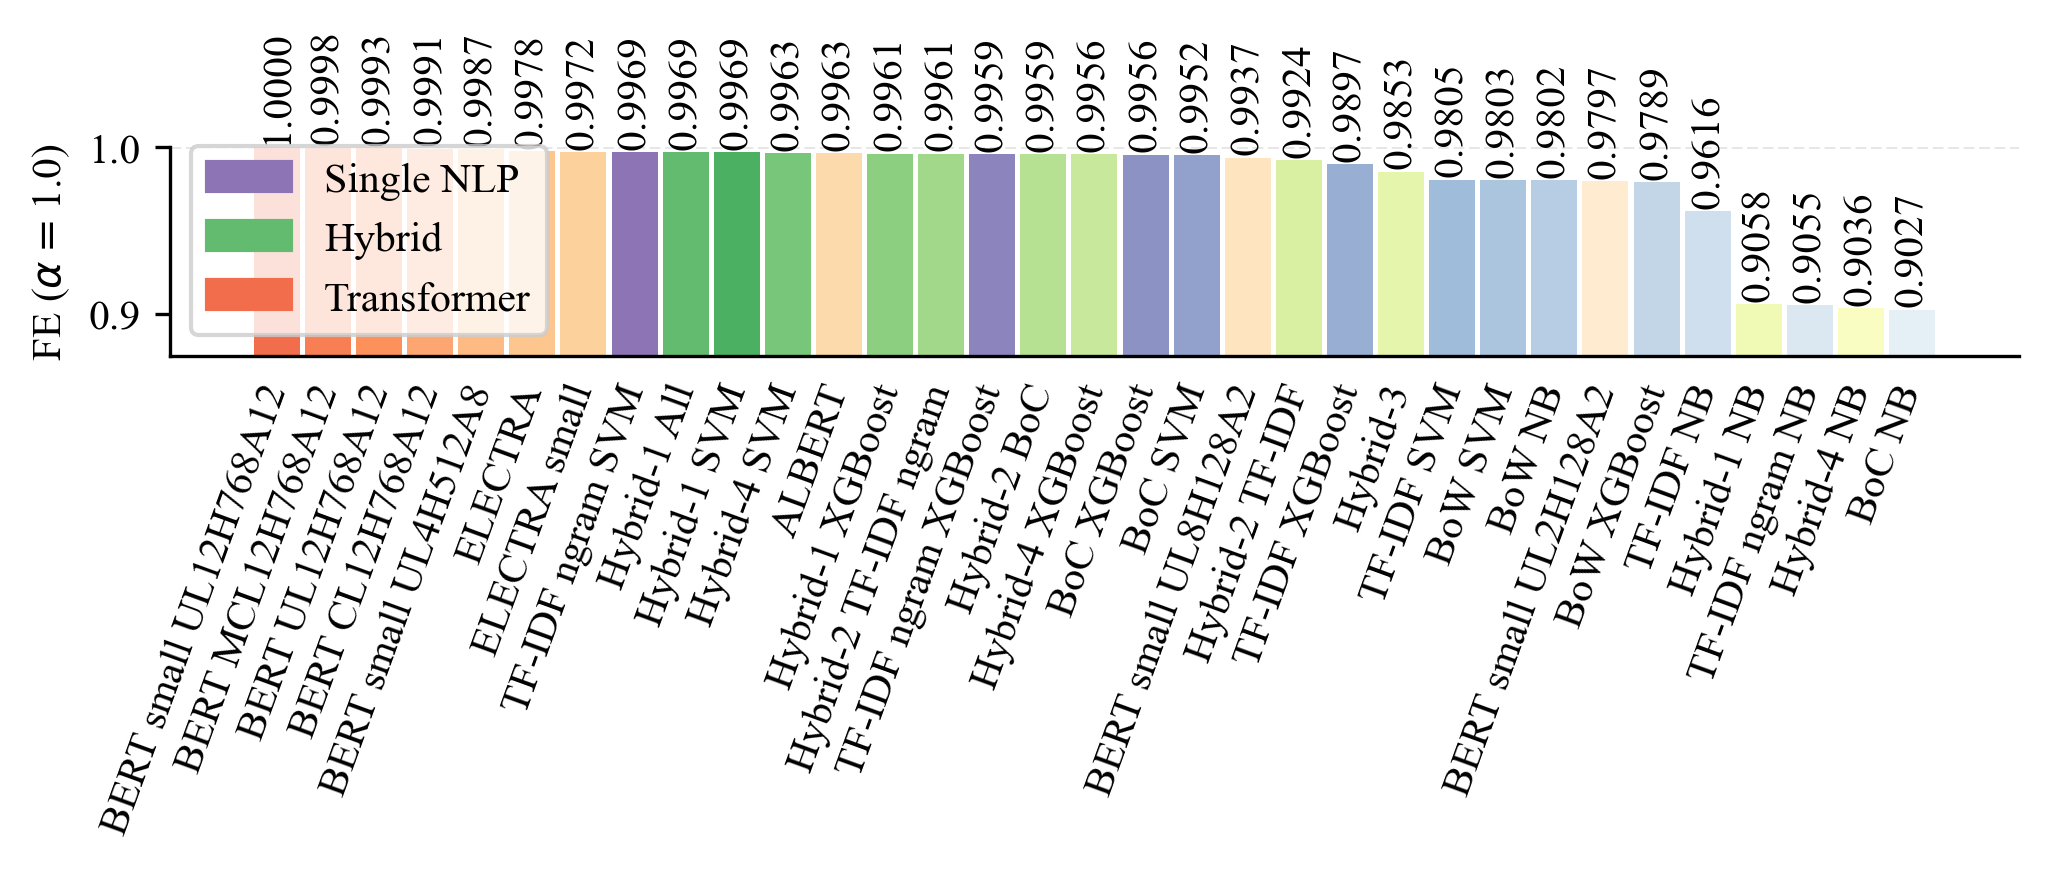

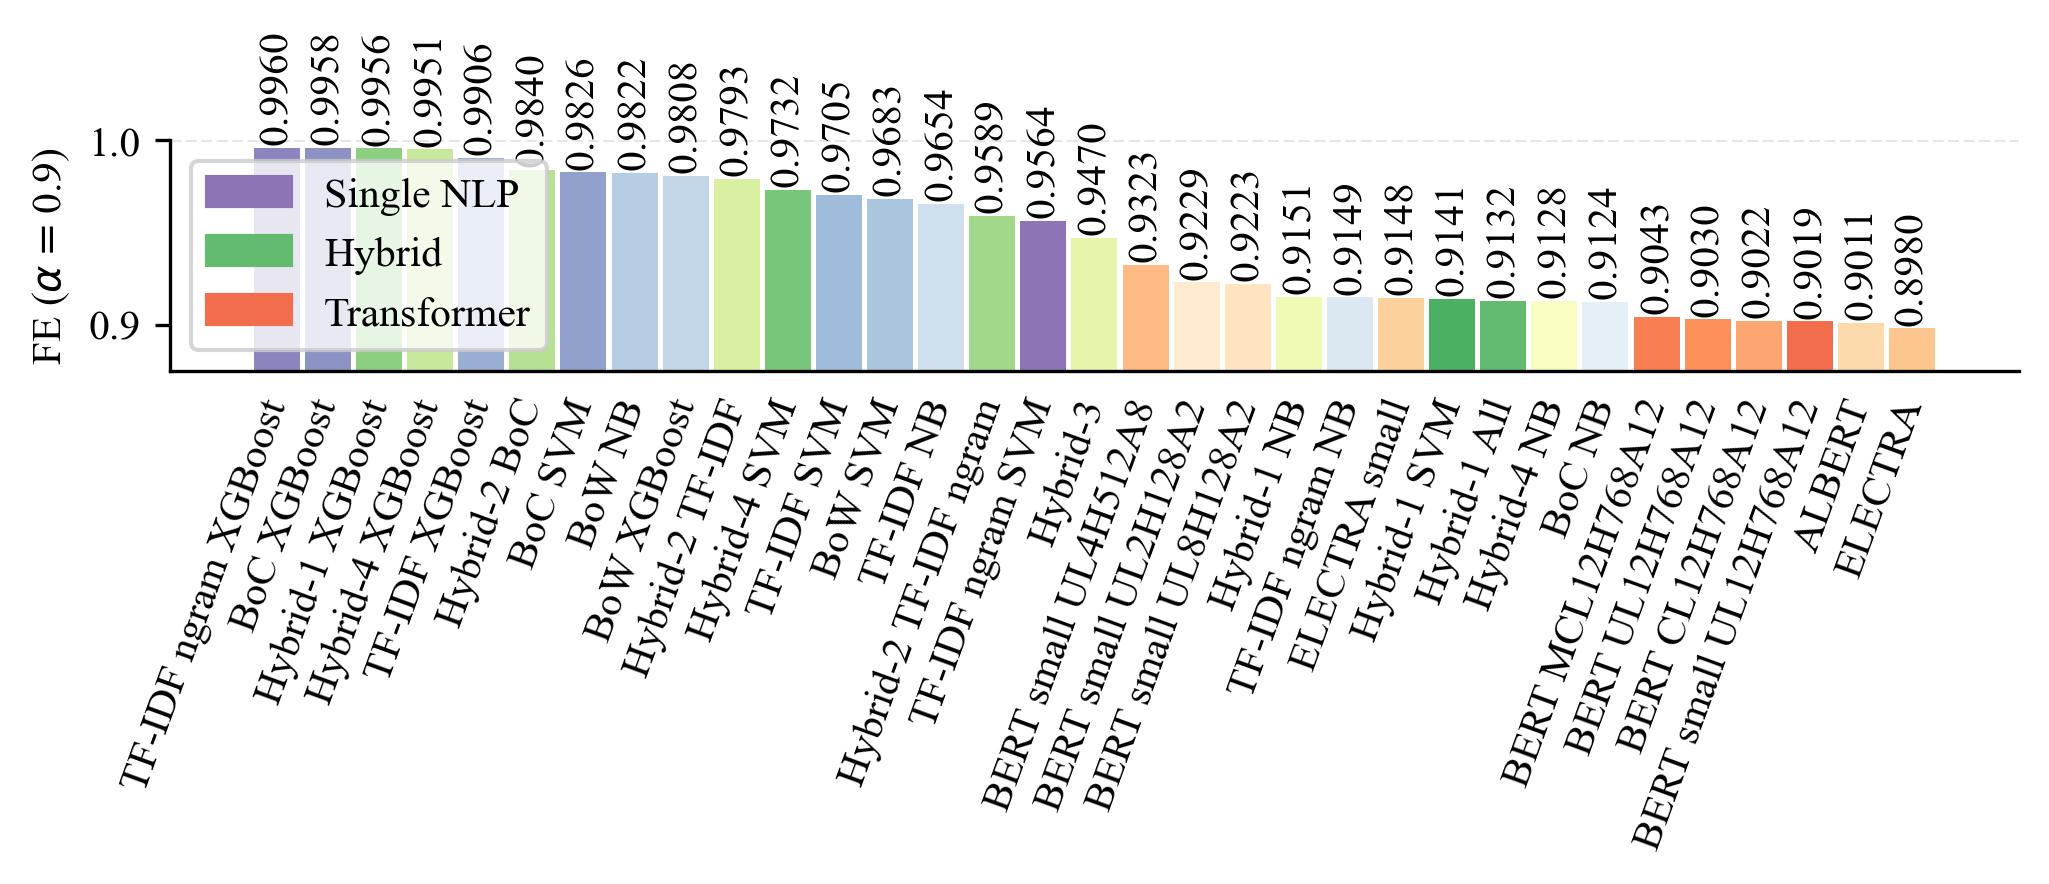

In [45]:
#ALL FE comparison for different alpha
from sklearn import preprocessing

current_figure_name = 'all_nlp_FE_alpha_100.png'

#df_small = df.sort_values(['category','f1'],ascending=[True, False])
df_small = df.sort_values('f1',ascending=False)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(1.0000 - df_small['testing time'].to_numpy().reshape(-1, 1))
df_small['inference scaled'] = x_scaled

alpha = 1.0
#alpha=1.00 #emphasis on F1 rather than speed
df_small['FE_100'] = alpha*df_small['f1'] + (1-alpha)*df_small['inference scaled']
#print(df_small)
alpha = 0.9
df_small['FE_090'] = alpha*df_small['f1'] + (1-alpha)*df_small['inference scaled']

df_small = rename_table_labels(df_small)



# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='classic_ml'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
color_cat_2 = np.asarray(df_small[df_small['category']=='hybrid'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
color_cat_3 = np.asarray(df_small[df_small['category']=='transformer'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
legend_cat_1 = mpatches.Patch(color=color_cat_1, label='Single NLP')
legend_cat_2 = mpatches.Patch(color=color_cat_2, label='Hybrid')
legend_cat_3 = mpatches.Patch(color=color_cat_3, label='Transformer')

# Figure
fig, ax = plt.subplots(figsize=(7, 3))
df_small = df_small.sort_values('FE_100',ascending=False)

my_plot_bar(df_small,ax,'FE_100')
plt.axhline(1, linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)

ax.set_ylabel('FE'+ r' ($\alpha=$' + f'{1.0})')
#ax.set_xlabel(r'$\alpha=$' + f'{alpha}')
ax.set(ylim=(0.875, 1))
ax.legend(handles=[legend_cat_1, legend_cat_2, legend_cat_3],  loc='lower left')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax.get_figure().savefig(figure_folder / current_figure_name)

#########################
current_figure_name = 'all_nlp_FE_alpha_090.png'
fig, ax = plt.subplots(figsize=(7, 3))
df_small = df_small.sort_values('FE_090',ascending=False)
my_plot_bar(df_small,ax,'FE_090')
plt.axhline(1, linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set_ylabel('FE'+ r' ($\alpha=$' + f'{0.9})')
#ax.set_xlabel()
ax.set(ylim=(0.875, 1))
ax.legend(handles=[legend_cat_1, legend_cat_2, legend_cat_3],  loc='lower left')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax.get_figure().savefig(figure_folder / current_figure_name)

# TODO
- 

# End